In [1]:
import numpy as np
np.random.seed(42)
import torch
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
import random
random.seed(42)

from scene import Scene
import os
import subprocess
from tqdm import tqdm
from os import makedirs
from gaussian_renderer import render
import torchvision
from utils.general_utils import safe_state
from argparse import ArgumentParser
from arguments import ModelParams, PipelineParams, get_combined_args, pose_estimation_params
from gaussian_renderer import GaussianModel
from utils.image_utils import psnr
from utils.loss_utils import EdgeDetection
import numpy as np
from utils.loss_utils import l1_loss, ssim, l2_loss
from copy import deepcopy
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity as LPIPS
import pypose as pp

from scene.dataset_readers import readColmapSceneInfo
from utils.camera_utils import loadCam
from collections import namedtuple
from matplotlib import pyplot as plt


import torch
import math
from diff_gaussian_rasterization import GaussianRasterizationSettings, GaussianRasterizer
from scene.gaussian_model import GaussianModel
from utils.sh_utils import eval_sh

import pickle

from scene.dataset_readers import CameraInfo
from PIL import Image
import mrob
import open3d as o3d


import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import imageio.v3 as imageio
import json
import cv2
from tqdm import tqdm
import open3d as o3d
import shutil
import mrob
import subprocess
from joblib import Parallel, delayed

from pytorch3d import io
import torch
from pytorch3d.renderer.cameras import FoVPerspectiveCameras, PerspectiveCameras
from pytorch3d.renderer.points.rasterizer import PointsRasterizer, PointsRasterizationSettings
from pytorch3d.structures import Pointclouds
from pytorch3d.utils import cameras_from_opencv_projection 
from pytorch3d.renderer import (
    PointsRenderer,
    NormWeightedCompositor
)

from scene.dataset_readers import readColmapSceneInfo
from utils.camera_utils import loadCam
from collections import namedtuple
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import mrob
from tqdm import tqdm
from joblib import Parallel, delayed
import os
import pickle
import cv2

# from run_extractor import compute_point_cloud_camera_fraction, compute_iou_2sets


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def compute_point_cloud_camera_fraction(R, tvec, fx, fy, cx, cy, height, width, points):
    camera_matrix = torch.tensor([[fx, 0, cx],
                               [0, fy, cy],
                               [0,0,1]])
    # R = [camera.R for camera in cameras]
    # tvec = [camera.T for camera in cameras]

    print(torch.tensor(np.array(R)).unsqueeze(0).float().shape)

    camera_p3d = cameras_from_opencv_projection(R = torch.tensor(np.array(R)).unsqueeze(0).float(), 
                                                tvec = torch.tensor(np.array(tvec)).unsqueeze(0).float(), 
                                                camera_matrix = camera_matrix.unsqueeze(0).float(),
                                                image_size = torch.tensor([height, 
                                                                          width]).unsqueeze(0).float())
    
    raster_settings = PointsRasterizationSettings(
                    image_size=(height, 
                                width), 
                    radius = 0.025,
                    points_per_pixel = 1
                    )
    rendered = PointsRasterizer(cameras=camera_p3d.cuda(), raster_settings=raster_settings)(points)
    rasterizer = PointsRasterizer(cameras=camera_p3d.cuda(), raster_settings=raster_settings)

    renderer = PointsRenderer(
        rasterizer=rasterizer,
        # Pass in background_color to the alpha compositor, setting the background color 
        # to the 3 item tuple, representing rgb on a scale of 0 -> 1, in this case blue
        compositor=NormWeightedCompositor()
    )
    print(renderer)
    images = renderer(points)
    return images

    # Create a points rasterizer
    fraction_set = set(torch.unique(PointsRasterizer(cameras=camera_p3d.cuda(), raster_settings=raster_settings)(points).idx)[1:].tolist())

    return fraction_set

In [3]:
gaussians = GaussianModel(sh_degree=3)

In [4]:
ply_path = '/mnt/sdb1/home/kbotashev/mip-nerf_projects/gaussian_splatting_original/output/iros_paper_replica_dataset_office_4_van/point_cloud/iteration_40000/point_cloud.ply'
gaussians.load_ply(ply_path)

In [5]:
scene_info = readColmapSceneInfo('/mnt/sdb1/home/kbotashev/iros_paper/replica_dataset/scenes/office_4/office_4_task', 'images', eval=False)

Reading camera 32/32


In [6]:
args = namedtuple('args', ['resolution', 'data_device'])
args = args(4, 'cuda:1')
pipe = namedtuple('pipe', ['convert_SHs_python', 'compute_cov3D_python', 'debug'])
pipe = pipe(False, False, False)
bg_color = [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

In [30]:
ply_path = os.path.join('/mnt/sdb1/home/kbotashev/iros_paper/replica_dataset/scenes/office_4/office_4_base/sparse/0/points3D.ply')
task_dir_path = os.path.join(ply_path.replace('_base/sparse/0/points3D.ply', '_task'))
# task_dir_path = '/mnt/sdb1/home/kbotashev/iros_paper/replica_dataset/office_4/office_4_task/'
scene_info = readColmapSceneInfo(task_dir_path, 'images', eval=False)

pcd_o3d = o3d.io.read_point_cloud(ply_path)
pcd_o3d = pcd_o3d.voxel_down_sample(voxel_size=0.025)
points_tensor = torch.tensor(np.asarray(pcd_o3d.points)).unsqueeze(0).cuda().float()
colors_tensor = torch.tensor(np.asarray(pcd_o3d.colors)).unsqueeze(0).cuda().float()
points = Pointclouds(points_tensor, features=colors_tensor)

args = namedtuple('args', ['resolution', 'data_device'])
args = args(2, 'cuda')
pipe = namedtuple('pipe', ['convert_SHs_python', 'compute_cov3D_python', 'debug'])
pipe = pipe(False, False, False)
bg_color = [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

ids = np.arange(len(scene_info.train_cameras))[0]

# scene_results = {}
# scene_results['point_cloud_path'] = ply_path
# scene_results['scene'] = ply_path.split('/')[-5]
# scene_results['frames'] = {}
id = 0

cam_info = scene_info.train_cameras[id]
camera = loadCam(args=args, id = id, cam_info=cam_info, resolution_scale=1)

height = camera.image_height
width = camera.image_width
fx = camera.fx
fy = camera.fy
cx = camera.cx
cy = camera.cy
frames_info = {}
frames_info['point_cloud_path'] = ply_path
frames_info['scene'] = ply_path.split('/')[-5]
frames_info['img_name'] = cam_info.image_name

frame_results = {np.round(iou_bin, 2):[] for iou_bin in np.linspace(0,1,21)}

rot = qvec2rotmat(camera.qvec)

T_gt = mrob.geometry.SE3(mrob.geometry.SO3(rot), camera.T)

set_gt = compute_point_cloud_camera_fraction(**{'R':T_gt.R(), 'tvec':T_gt.t(), 
                        "fx":fx, 'fy':fy, 
                        'cx':cx, 'cy':cy, 
                        'height':height, 'width':width, 
                        'points':points})

for noise_level in np.linspace(0,0.3,1000).tolist() + np.linspace(0.3,1,1000).tolist():
    tries = 1
    for num_try in range(tries):
        perturbation = np.random.randn(6)*noise_level
        print(perturbation)
        T_init = mrob.geometry.SE3(perturbation).mul(T_gt)

        image_init = compute_point_cloud_camera_fraction(**{'R':rot, 'tvec':camera.T, 
                        "fx":fx, 'fy':fy, 
                        'cx':cx, 'cy':cy, 
                        'height':height, 'width':width, 
                        'points':points,
                        })
        
        norm_image = cv2.normalize(image_init[0].cpu().numpy(), None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

        norm_image = norm_image.astype(np.uint8)

        # iou, intersection_indices, union_indices = compute_iou_2sets(set_gt, set_init)

        # frame_results[np.round(np.round(iou/0.05)*0.05,2)].append({'R_init':T_init.R(),
        #                                             'T_init':T_init.t(),
        #                                                 'iou':iou,
        #                                                 'init_fraction_set_idx':list(set_init),
        #                                                 'intersection_idx':intersection_indices,
        #                                                 'union_idx':union_indices,
        #                                                 'init_image':norm_image
        #                                                 })
    break        
frames_info['frames'] = {'img_path':cam_info.image_path,
                        'R':cam_info.R,
                        'T':cam_info.T,
                        'uid':id,
                        'FovY':cam_info.FovY,
                        'FovX':cam_info.FovX,
                        'image':np.array(cam_info.image),
                        'width':cam_info.width,
                        'height':cam_info.height,
                        'qvec':cam_info.qvec,
                        'cx':cam_info.cx,
                        'cy':cam_info.cy,
                        'gt_fraction_set_idx':list(set_gt),
                        'init_frames_iou_bins':frame_results,
                        # 'init_frames_iou_bins_stats':init_frames_stats
                        }

Reading camera 32/32


/mnt/sdb1/home/kbotashev/mip-nerf_projects/gaussian_splatting_original/gaussian-splatting/scene/cameras.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.world_view_transform_lie = pp.SE3(torch.tensor(world_view_transform))


torch.Size([1, 3, 3])
PointsRenderer(
  (rasterizer): PointsRasterizer(
    (cameras): PerspectiveCameras()
  )
  (compositor): NormWeightedCompositor()
)
[-0.  0. -0. -0.  0. -0.]
torch.Size([1, 3, 3])
PointsRenderer(
  (rasterizer): PointsRasterizer(
    (cameras): PerspectiveCameras()
  )
  (compositor): NormWeightedCompositor()
)


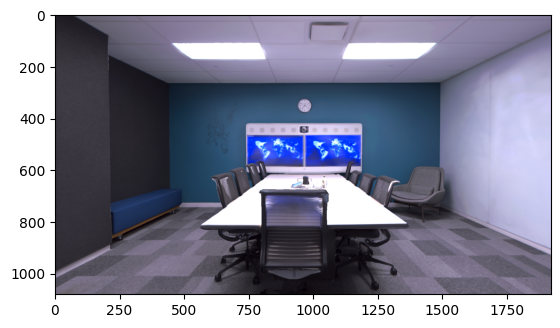

In [31]:
plt.imshow(np.array(cam_info.image))

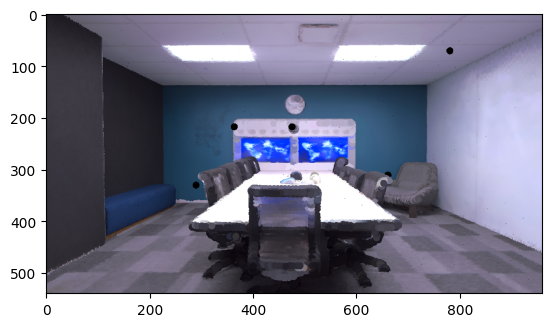

In [32]:
plt.imshow(norm_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


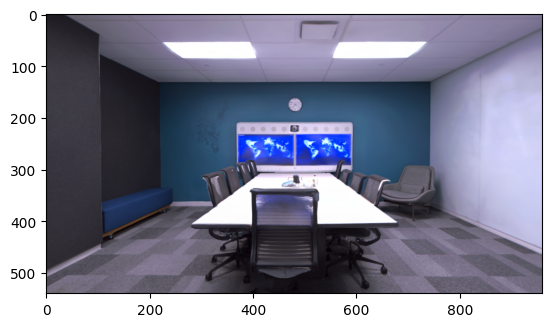

In [33]:
plt.imshow(render(camera, gaussians, pipe, background)['render'].detach().cpu().numpy().transpose(1,2,0))

In [29]:
camera.R, camera.T

(array([[-9.94522153e-01, -1.04526015e-01, -1.81654761e-11],
        [-1.82458464e-03,  1.73601745e-02, -9.99847636e-01],
        [ 1.04510089e-01, -9.94370623e-01, -1.74557946e-02]]),
 array([2.1635845 , 0.04362836, 3.22975805]))

In [9]:
camera.qvec

array([ 0.03668183,  0.03732783, -0.7122742 ,  0.69994753])

In [14]:
qvec2rotmat(camera.qvec)

array([[ 9.94522153e-01, -1.04526015e-01, -1.81654761e-11],
       [-1.82458464e-03, -1.73601745e-02, -9.99847636e-01],
       [ 1.04510089e-01, -9.94370623e-01,  1.74557946e-02]])

In [30]:
T_gt.R(), T_gt.t()

(array([[-9.94522153e-01, -1.04526015e-01, -1.81654761e-11],
        [-1.82458464e-03,  1.73601745e-02, -9.99847636e-01],
        [ 1.04510089e-01, -9.94370623e-01, -1.74557946e-02]]),
 array([2.1635845 , 0.04362836, 3.22975805]))

In [18]:
def qvec2rotmat(qvec):
    return np.array([
        [1 - 2 * qvec[2]**2 - 2 * qvec[3]**2,
         2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
         2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2]],
        [2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
         1 - 2 * qvec[1]**2 - 2 * qvec[3]**2,
         2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1]],
        [2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
         2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
         1 - 2 * qvec[1]**2 - 2 * qvec[2]**2]])

In [32]:
import numpy as np
np.random.seed(42)
import torch
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
import random
random.seed(42)

from scene import Scene
import os
import subprocess
from tqdm import tqdm
from os import makedirs
from gaussian_renderer import render
import torchvision
from utils.general_utils import safe_state
from argparse import ArgumentParser
from arguments import ModelParams, PipelineParams, get_combined_args, pose_estimation_params
from gaussian_renderer import GaussianModel
from utils.image_utils import psnr
from utils.loss_utils import EdgeDetection
import numpy as np
from utils.loss_utils import l1_loss, ssim, l2_loss
from copy import deepcopy
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity as LPIPS
import pypose as pp

from scene.dataset_readers import readColmapSceneInfo
from utils.camera_utils import loadCam
from collections import namedtuple
from matplotlib import pyplot as plt


import torch
import math
from diff_gaussian_rasterization import GaussianRasterizationSettings, GaussianRasterizer
from scene.gaussian_model import GaussianModel
from utils.sh_utils import eval_sh

import pickle

from scene.dataset_readers import CameraInfo
from PIL import Image
import mrob
import open3d as o3d

In [33]:
gaussians = GaussianModel(sh_degree=3)

In [34]:
ply_path = '/mnt/sdb1/home/kbotashev/mip-nerf_projects/gaussian_splatting_original/output/iros_paper_replica_dataset_office_4_van/point_cloud/iteration_40000/point_cloud.ply'
gaussians.load_ply(ply_path)

In [35]:
scene_info = readColmapSceneInfo('/mnt/sdb1/home/kbotashev/iros_paper/replica_dataset/scenes/office_4/office_4_task', 'images', eval=False)

Reading camera 32/32


In [36]:
args = namedtuple('args', ['resolution', 'data_device'])
args = args(4, 'cuda:1')
pipe = namedtuple('pipe', ['convert_SHs_python', 'compute_cov3D_python', 'debug'])
pipe = pipe(False, False, False)
bg_color = [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

In [41]:
frames_info['frames']['init_frames_iou_bins']

{0.0: [],
 0.05: [],
 0.1: [],
 0.15: [],
 0.2: [],
 0.25: [],
 0.3: [],
 0.35: [],
 0.4: [],
 0.45: [],
 0.5: [],
 0.55: [],
 0.6: [],
 0.65: [],
 0.7: [],
 0.75: [],
 0.8: [],
 0.85: [],
 0.9: [],
 0.95: [],
 1.0: [{'R_init': array([[-9.94522153e-01, -1.04526015e-01, -1.81654761e-11],
          [-1.82458464e-03,  1.73601745e-02, -9.99847636e-01],
          [ 1.04510089e-01, -9.94370623e-01, -1.74557946e-02]]),
   'T_init': array([2.1635845 , 0.04362836, 3.22975805]),
   'iou': 1.0,
   'init_fraction_set_idx': [131073,
    2,
    3,
    4,
    6,
    7,
    8,
    131078,
    10,
    131079,
    131081,
    13,
    14,
    15,
    131082,
    17,
    131091,
    20,
    21,
    22,
    23,
    24,
    25,
    26,
    27,
    131096,
    29,
    30,
    131103,
    131104,
    33,
    131105,
    35,
    37,
    38,
    131110,
    40,
    41,
    131112,
    43,
    44,
    131117,
    46,
    48,
    49,
    131121,
    131122,
    53,
    54,
    55,
    56,
    131127,
    58,
    

In [ ]:
FovY = frames_info['frames']['FovY']
FovX = frames_info['frames']['FovX']
width = frames_info['frames']['width']
height = frames_info['frames']['height']
cx = frames_info['frames']['cx']
cy = frames_info['frames']['cy']

image_gt = Image.fromarray(frames_info['frames']['image'])
image_path = frames_info['frames']['img_path']
image_name = frames_info['img_name']

R_gt = frames_info['frames']['R']
t_gt = frames_info['frames']['T']


cam_info_gt = CameraInfo(uid=0, R=R_gt, T=t_gt, FovY=FovY, FovX=FovX, image=image_gt,
                         image_path=image_path, image_name=image_name, width=width,
                         height=height, qvec = None, cx = cx, cy = cy)

iou_bin = 0.85
index = 10

R_init = frames_info['frames']['init_frames_iou_bins'][iou_bin][index]['R_init']
t_init = frames_info['frames']['init_frames_iou_bins'][iou_bin][index]['T_init']
intersection_indices = frames_info['frames']['init_frames_iou_bins'][iou_bin][index]['intersection_idx']
union_indices = frames_info['frames']['init_frames_iou_bins'][iou_bin][index]['union_idx']

# T_init = mrob.geometry.SE3(mrob.geometry.SO3(R_init), t_init)
# T_init = mrob.geometry.SE3(T_init.T() @ )

# R_init = T_init.R()
# t_init = T_init.t()

iou_value = frames_info['frames']['init_frames_iou_bins'][iou_bin][index]['iou']
image_init = frames_info['frames']['init_frames_iou_bins'][iou_bin][index]['init_image']

cam_info_init = CameraInfo(uid=0, R=R_init, T=t_init, FovY=FovY, FovX=FovX, image=image_gt,
                         image_path=image_path, image_name=image_name, width=width,
                         height=height, qvec = None, cx = cx, cy = cy)

In [ ]:
camera_gt = loadCam(args=args, id = 0, cam_info=cam_info_gt, resolution_scale=1)

camera_init = loadCam(args=args, id = 0, cam_info=cam_info_init, resolution_scale=1)

# camera = Camera(colmap_id=cam_info.uid, R=cam_info.R, T=cam_info.T, qvec = cam_info.qvec,
#                   FoVx=cam_info.FovX, FoVy=cam_info.FovY, 
#                   image=gt_image, gt_alpha_mask=loaded_mask, cx = cam_info.cx/scale, cy = cam_info.cy/scale,
#                   image_name=cam_info.image_name, uid=id, data_device=args.data_device)

/mnt/sdb1/home/kbotashev/mip-nerf_projects/gaussian_splatting_original/gaussian-splatting/scene/cameras.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.world_view_transform_lie = pp.SE3(torch.tensor(world_view_transform))


In [ ]:
result = render(camera_init, gaussians, pipe, background)